# Topic Modelling Twitter
*Author: Yasir Abdur Rohman*

In [1]:
# import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import dotenv
import os
from dotenv import load_dotenv

# import tweepy
import tweepy

# datetime
from datetime import datetime, timedelta

# plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go

init_notebook_mode(connected=True) #do not miss this line

# gensim
from gensim import corpora, models, similarities

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load env file
load_dotenv(".env")

# setting API Twitter
TWITTER_API_KEY = os.getenv('TWITTER_API_KEY')
TWITTER_API_SECRET_KEY = os.getenv('TWITTER_API_SECRET_KEY')
TWITTER_ACCESS_TOKEN = os.getenv('TWITTER_ACCESS_TOKEN')
TWITTER_ACCESS_TOKEN_SECRET = os.getenv('TWITTER_ACCESS_TOKEN_SECRET')

auth = tweepy.OAuthHandler(TWITTER_API_KEY, TWITTER_API_SECRET_KEY)
auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [3]:
# initialize crawler parameters

# date
maximum_days = 7
today = datetime.today()
date_max = today - timedelta(days=maximum_days)

# query
query = "#Udacity OR #udacity OR Udacity OR udacity"

In [4]:
# initialize dataframe
df_tweet = pd.DataFrame({'user_id': [], 'username': [], 'created_at': [], 'text': []})

# crawling tweet documents
c = tweepy.Cursor(api.search, q=query, tweet_mode='extended').items()
while True:
    try:
        tweet = c.next()
        
        # get clean tweet without RT
        if (not tweet.retweeted) and ('RT @' not in tweet.full_text):
            user_id = tweet.user.id
            username = tweet.user.screen_name
            created = tweet.created_at
            text = tweet.full_text.encode('utf-8', 'ignore').decode('utf-8', 'ignore')

            # get tweet documents before maximum_days
            if tweet.created_at < date_max:
                break
            df_tweet = df_tweet.append({'user_id': user_id, 'username': username, 
                                        'created_at': created, 'text': text}, ignore_index=True)
                       
    except tweepy.TweepError as e:
        print(e.reason)
        time.sleep(15 * 60)
        continue
    except StopIteration:
        break

In [5]:
df_tweet.head(10)

,user_id,username,created_at,text
0,2.405739e+08,FFDAfrica,2019-08-19 07:02:35,"Join World-Famous Computer Scientist, Educator..."
1,1.155052e+18,unrobotico,2019-08-19 06:19:11,Completed my First Project of @udacity Self-Dr...
2,2.099899e+08,l39_driver_jp,2019-08-19 06:09:27,２、オンラインプログラミングスクールのUdacityの自動運転車コース（SDC)を履修して最...
3,1.155052e+18,unrobotico,2019-08-19 06:06:59,I completed Finding Lane Lines! I've just begu...
4,9.038377e+08,ninenty_,2019-08-19 05:03:05,@MayibongweBongo Yea atleast let her https://t...
5,1.134591e+18,Ibrahimarazaq,2019-08-19 03:55:35,You could learn from these places;\n- Khan Aca...
6,2.695042e+08,DennisDadOf3,2019-08-19 01:58:23,"My new future starts today, I graduated from U..."
7,1.420129e+07,NavSha,2019-08-19 01:53:31,@aaronhma @udacity @coursera @Waymo @voyage @z...
8,8.409513e+17,luanleonardov,2019-08-19 01:48:26,5 Skills You Need to Become a Machine Learning...
9,9.370123e+17,aaronhma,2019-08-19 01:45:51,After graduating from both @udacity and @cours...


In [6]:
range(len(df_tweet['text']))

range(0, 502)

## Tweet Activity

References: https://www.kaggle.com/errearanhas/topic-modelling-lda-on-elon-tweets

In [7]:
df_tweet.dtypes

user_id              float64
username              object
created_at    datetime64[ns]
text                  object
dtype: object

In [8]:
# df_tweet['created_at'] = df_tweet['created_at'].dt.strftime('%y-%m-%d %H:%M:%S')
tweetsT = df_tweet['created_at'] 


trace = go.Histogram(
    x=tweetsT,
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Tweet Activity',
    height=450,
    width=1000,
    xaxis=dict(
        title='Date'
    ),
    yaxis=dict(
        title='Tweet Quantity'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

## Make Corpus

In [9]:
corpus = list()
a = list()
for i in range(len(df_tweet['text'])):
    a = df_tweet['text'][i]
    corpus.append(a)

In [10]:
corpus[0:5]

['Join World-Famous Computer Scientist, Educator, Inventor &amp; Entrepreneur Sebastian Thrun for a Free Live Webcast Conversation &amp; Q&amp;A on Friday, August 23rd 11am Pacific Time\nhttps://t.co/gJAO7F0O0l',
 'Completed my First Project of @udacity Self-Driving Cars Nanodegree. So happy with the review 😃!!\n#ChallengeAccepted #Challenge1 #UdacityLevelUp #SelfDrivingUdacity https://t.co/KqFELaA2fl',
 '２、オンラインプログラミングスクールのUdacityの自動運転車コース（SDC)を履修して最終プロジェクトに進む。最終プロジェクトの自動運転プログラムは実際に車に載せて検証される。コースはだいたい24万円くらいだけど、検証を自分の目でみるにはサンフランシスコまで行かなくてはならない。（続く）',
 "I completed Finding Lane Lines! I've just begun my journey with the Self-Driving Car Engineer Nanodegree @udacity https://t.co/5Z8AyxNEj5 #selfdrivingudacity https://t.co/Gjf6eHrPuh",
 '@MayibongweBongo Yea atleast let her https://t.co/9TMZXJGH2A hurts more to be told that i loved you but you could not see it.']

In [11]:
import gensim
import logging
import tempfile

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

from gensim import corpora
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "C:\Users\YASIRA~1\AppData\Local\Temp" will be used to save temporary dictionary and corpus.


In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from string import punctuation
import string
from unicodedata import normalize
import re

def remove_url(tweet):
    """Remove URL link.
    Args:
        tweet(str): tweet
    Returns:
        modified tweet
    """
    tweet = re.sub(r"\s—\s", "", tweet)
    tweet = re.sub(r"http\S+", "", tweet)
    return tweet

def remove_hashtag_mention(tweet):
    """Remove hastag and mention.
    Args:
        tweet(str): tweet
    Returns:
        modified tweet
    """
    result = []
    tweet = tweet.split(' ')
    for t in tweet:
        if t.startswith('#') or t.startswith('@'):
            continue
        else:
            result.append(t)
    return ' '.join(result)

def remove_rt_fav(tweet):
    """Remove RT and FAV.
    Args:
        tweet(str): tweet
    Returns:
        modified tweet
    """
    tweet = re.sub(r'^(RT|FAV)','', tweet)
    return tweet

def remove_punctuation(tweet):
    """Remove punctuation except '-'.
    Args:
        tweet(str): tweet
    Returns:
        modified tweet
    """
    remove = string.punctuation
    translator = str.maketrans(remove, ' '*len(remove))
    return tweet.translate(translator)
    
def remove_ascii_unicode(tweet):
    """Remove ASCII and Unicode.
    Args:
        tweet(str): tweet
    Returns:
        modified tweet
    """
    tweet = normalize('NFKD', tweet)
    tweet = tweet.encode('ascii', 'ignore').decode('utf-8')
    return tweet

def remove_newline(tweet):
    """Remove newline.
    Args:
        tweet(str): tweet
    Returns:
        modified tweet
    """
    tweet = tweet.replace('\n', ' ')
    return tweet

[nltk_data] Downloading package stopwords to C:\Users\Yasir Abdur
[nltk_data]     Rohman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# preprocessing tweet documents
corpus_preprocessed = list()

for doc in corpus:
    doc = remove_ascii_unicode(doc)
    doc = doc.lower()
    doc = remove_rt_fav(doc)
    doc = remove_newline(doc)
    doc = remove_url(doc)
    doc = remove_hashtag_mention(doc)
    doc = remove_punctuation(doc)
    
    corpus_preprocessed.append(doc)

# remove common words and tokenize
list1 = ['RT','rt', 'udacity']
stoplist = stopwords.words('english') + list(punctuation) + list1

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus_preprocessed]

In [14]:
dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'tweet_documents.dict'))  # store the dictionary, for future reference
print(dictionary)

2019-08-19 14:27:58,418 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-08-19 14:27:58,426 : INFO : built Dictionary(2006 unique tokens: ['11am', '23rd', 'amp', 'august', 'computer']...) from 502 documents (total 5294 corpus positions)
2019-08-19 14:27:58,427 : INFO : saving Dictionary object under C:\Users\YASIRA~1\AppData\Local\Temp\tweet_documents.dict, separately None
2019-08-19 14:27:58,429 : INFO : saved C:\Users\YASIRA~1\AppData\Local\Temp\tweet_documents.dict


Dictionary(2006 unique tokens: ['11am', '23rd', 'amp', 'august', 'computer']...)


In [15]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'tweet_documents.mm'), corpus)  # store to disk, for later use

2019-08-19 14:27:58,439 : INFO : storing corpus in Matrix Market format to C:\Users\YASIRA~1\AppData\Local\Temp\tweet_documents.mm
2019-08-19 14:27:58,440 : INFO : saving sparse matrix to C:\Users\YASIRA~1\AppData\Local\Temp\tweet_documents.mm
2019-08-19 14:27:58,440 : INFO : PROGRESS: saving document #0
2019-08-19 14:27:58,449 : INFO : saved 502x2006 matrix, density=0.505% (5082/1007012)
2019-08-19 14:27:58,450 : INFO : saving MmCorpus index to C:\Users\YASIRA~1\AppData\Local\Temp\tweet_documents.mm.index


In [17]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

2019-08-19 14:27:58,463 : INFO : collecting document frequencies
2019-08-19 14:27:58,464 : INFO : PROGRESS: processing document #0
2019-08-19 14:27:58,465 : INFO : calculating IDF weights for 502 documents and 2006 features (5082 matrix non-zeros)


In [18]:
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors

In [19]:
total_topics = 5

In [20]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

2019-08-19 14:27:58,490 : INFO : using symmetric alpha at 0.2
2019-08-19 14:27:58,490 : INFO : using symmetric eta at 0.2
2019-08-19 14:27:58,491 : INFO : using serial LDA version on this node
2019-08-19 14:27:58,810 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 502 documents, updating model once every 502 documents, evaluating perplexity every 502 documents, iterating 50x with a convergence threshold of 0.001000
2019-08-19 14:27:58,812 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-08-19 14:27:59,067 : INFO : -9.628 per-word bound, 791.5 perplexity estimate based on a held-out corpus of 502 documents with 5294 words
2019-08-19 14:27:59,068 : INFO : PROGRESS: pass 0, at document #502/502
2019-08-19 14:27:59,251 : INFO : topic #0 (0.200): 0.015*"nanodegree" + 0.009*"program" + 0.007*"learning" + 0.007*"self" + 0.007*"driving" + 0.007*"learn" + 0

In [21]:
#Show first n important word in the topics:
lda.show_topics(total_topics, 5)

[(0,
  '0.015*"nanodegree" + 0.009*"program" + 0.007*"learning" + 0.007*"self" + 0.007*"driving"'),
 (1,
  '0.011*"course" + 0.009*"thanks" + 0.008*"thank" + 0.008*"learning" + 0.008*"nanodegree"'),
 (2,
  '0.010*"learning" + 0.009*"course" + 0.009*"day" + 0.007*"scholarship" + 0.007*"story"'),
 (3,
  '0.010*"day" + 0.008*"thank" + 0.008*"3" + 0.007*"nanodegree" + 0.007*"learning"'),
 (4,
  '0.020*"course" + 0.017*"learning" + 0.012*"amp" + 0.011*"new" + 0.011*"machine"')]

In [22]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}

In [23]:
df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(81, 5)
(5, 81)


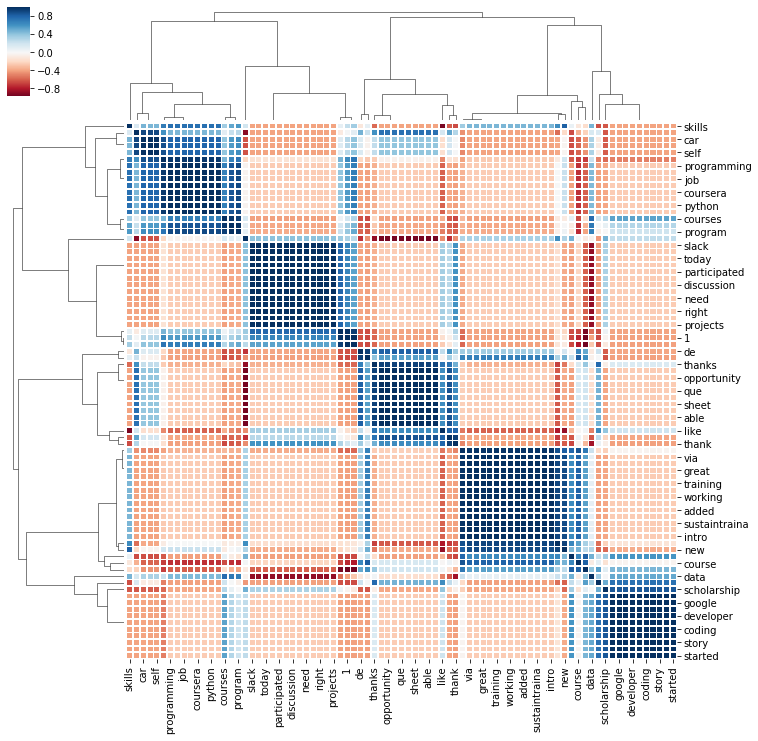

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g = sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [25]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
4      40.373302 -111.426277       1        1  51.833332
3      84.548668 -191.779434       2        1  18.053711
0     -39.978592 -155.600937       3        1  10.047696
1      22.284182 -173.689041       4        1  10.040479
2       4.195242 -235.953644       5        1  10.024783, topic_info=     Category      Freq           Term     Total  loglift  logprob
27    Default  3.000000     nanodegree  3.000000  30.0000  30.0000
299   Default  2.000000           data  2.000000  29.0000  29.0000
172   Default  1.000000        program  1.000000  28.0000  28.0000
475   Default  1.000000             de  1.000000  27.0000  27.0000
401   Default  1.000000         thanks  1.000000  26.0000  26.0000
30    Default  1.000000           self  1.000000  25.0000  25.0000
333   Default  2.000000          thank  2.000000  24.0000  24.0000
24    Default  1.000000        driving  1.000000  23.0000  23.0000
35    Default  1.000000            car  1.000000  22.0000  22.0000
62    Default  1.000000          learn  1.000000  21.0000  21.0000
69    Default  0.000000          udemy  0.000000  20.0000  20.0000
23    Default  1.000000      completed  1.000000  19.0000  19.0000
217   Default  4.000000            day  4.000000  18.0000  18.0000
233   Default  2.000000  sustaintraina  2.000000  17.0000  17.0000
406   Default  1.000000    scholarship  1.000000  16.0000  16.0000
162   Default  1.000000              3  1.000000  15.0000  15.0000
230   Default  2.000000          green  2.000000  14.0000  14.0000
229   Default  2.000000          added  2.000000  13.0000  13.0000
1266  Default  0.000000          story  0.000000  12.0000  12.0000
180   Default  1.000000           like  1.000000  11.0000  11.0000
232   Default  0.000000         python  0.000000  10.0000  10.0000
207   Default  6.000000         course  6.000000   9.0000   9.0000
201   Default  0.000000          build  0.000000   8.0000   8.0000
115   Default  1.000000      developer  1.000000   7.0000   7.0000
83    Default  1.000000         skills  1.000000   6.0000   6.0000
161   Default  1.000000              2  1.000000   5.0000   5.0000
80    Default  6.000000       learning  6.000000   4.0000   4.0000
268   Default  1.000000              1  1.000000   3.0000   3.0000
234   Default  2.000000       training  2.000000   2.0000   2.0000
284   Default  0.000000   participated  0.000000   1.0000   1.0000
...       ...       ...            ...       ...      ...      ...
1539   Topic5  0.085908           meet  0.200741   1.4514  -6.3730
58     Topic5  0.124272             go  0.298375   1.4242  -6.0038
364    Topic5  0.120621         school  0.292110   1.4156  -6.0336
718    Topic5  0.115620          swift  0.288006   1.3874  -6.0759
406    Topic5  0.362604    scholarship  1.062155   1.2254  -4.9329
115    Topic5  0.305626      developer  1.218308   0.9173  -5.1039
348    Topic5  0.250978        android  0.991972   0.9258  -5.3009
255    Topic5  0.173075           read  0.596760   1.0623  -5.6725
299    Topic5  0.330877           data  2.023060   0.4895  -5.0245
253    Topic5  0.176880           life  0.631562   1.0274  -5.6508
217    Topic5  0.441700            day  4.233937   0.0399  -4.7356
863    Topic5  0.128247            aws  0.353915   1.2850  -5.9723
302    Topic5  0.203863         google  0.931522   0.7807  -5.5088
80     Topic5  0.484621       learning  6.260059  -0.2585  -4.6429
207    Topic5  0.451286         course  6.920213  -0.4300  -4.7141
458    Topic5  0.190051         coding  0.964558   0.6757  -5.5790
28     Topic5  0.271498        project  2.320312   0.1546  -5.2223
224    Topic5  0.196097        started  1.067235   0.6059  -5.5476
180    Topic5  0.194208           like  1.044702   0.6176  -5.5573
1615   Topic5  0.138897             en  0.469848   1.0814  -5.8925
53     Topic5  0.218147        courses  1.489312   0.3792  -5.4411
164    